# Time series - introduction & ARIMA models

In this example, we'll explore parts of classical time series analysis and fit a few auto regressive models.

For more details on data transformation, model selection & forecasting [visit this site](http://people.duke.edu/~rnau/411home.htm)

Many useful details amy also be found in this [online book](https://bookdown.org/rdpeng/timeseriesbook/)

In [7]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
pd.options.display.max_rows = 10
matplotlib.rcParams['figure.figsize'] = (15, 6)

First, mount the data folder in your google drive.

**Make sure you have copied [this data folder](https://drive.google.com/open?id=1V1uNEs3IUNh3GxHzDBTrHEp7QyxT8yY7) to your personal Google drive** *

** Navigate to the `ml-college` folder drop-down menu name at the top and select "Add to my drive" or silimar*

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


We'll use the well-known air passengers time series for this example. Notice the date parsing function that allows us to build an index on this time series.

In [10]:
path = '/content/drive/My Drive/ml-college/time-series-analysis/data/AirPassengers.csv'
data = pd.read_csv(path, parse_dates=True, index_col='Month', date_parser=lambda x: datetime.strptime(x, '%Y-%m'))
ts = data['#Passengers']
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Now let's see how the time series looks like. 


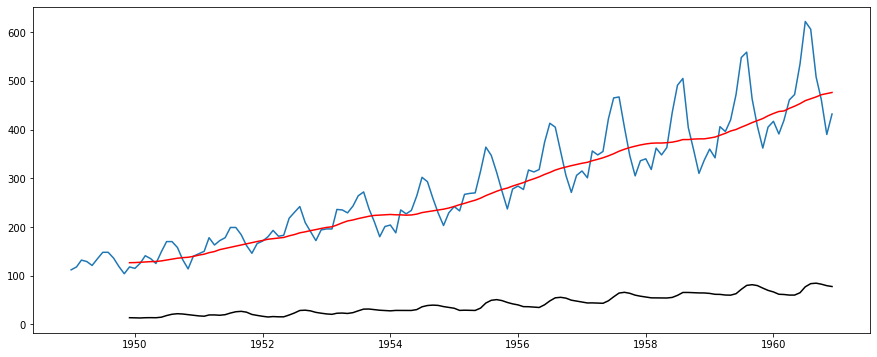

In [11]:
rolling = ts.rolling(center=False, window=12)        
plt.plot(ts)
plt.plot(rolling.mean(), color='red')
plt.plot(rolling.std(), color='black')
plt.show()

When we look at the data we generally want to understand the underlying process that generates such observations. The usual process is to identify various components and "explain them away". 

When all identifiable components are explained, we usually say that the rest is just random noise (there's not many other choices anyway)

When we look at the time series above, we can observe several components:

- **frequency** -- there's one sample per month
- **inflation** -- standard deviation is not constant in time
- **trend** -- mean is not constant in time
- **seasonality** -- there's a strong yearly pattern


## Inflation adjustment -- deflation

Monetary time series often contains an *inflation component* which affects the variance of the time series over time. To stabilize variance, one need to "deflate" the time series by dividing it by a specific index (for example the Consumer Price Index - CPI). 

There are many indices for various industry types you can select from but there's another way how to deflate a time series -- *natural logarithm*.

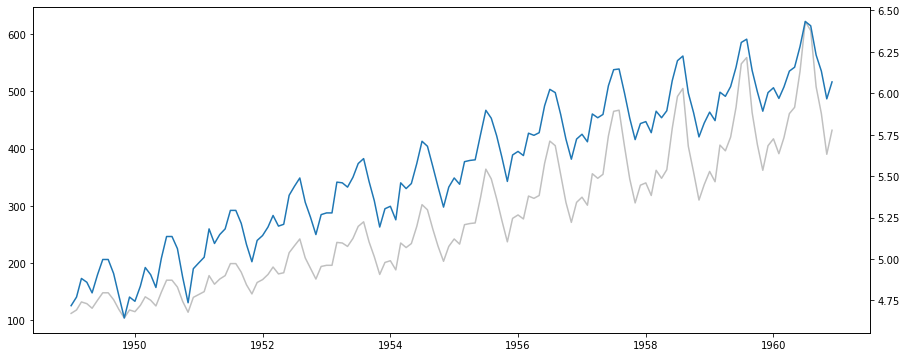

In [12]:
log_ts = np.log(ts)

plt.plot(ts, c='silver')
plt.twinx()
plt.plot(log_ts)
plt.show()

## Seasonal decomposition



Next, we can try *seasonal_decompose* library function that can perform trend & seasonality decomposion.

*Note: Look at [this notebook](https://notebook.community/jrmontag/Data-Science-45min-Intros/time-series/03%20-%20Seasonal-Trend%20Decomposition) for explanation how `seasonal_decompose` in `stats_models` works*

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decomposition(decomposition):
    
    plt.figure(figsize=(15,10))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


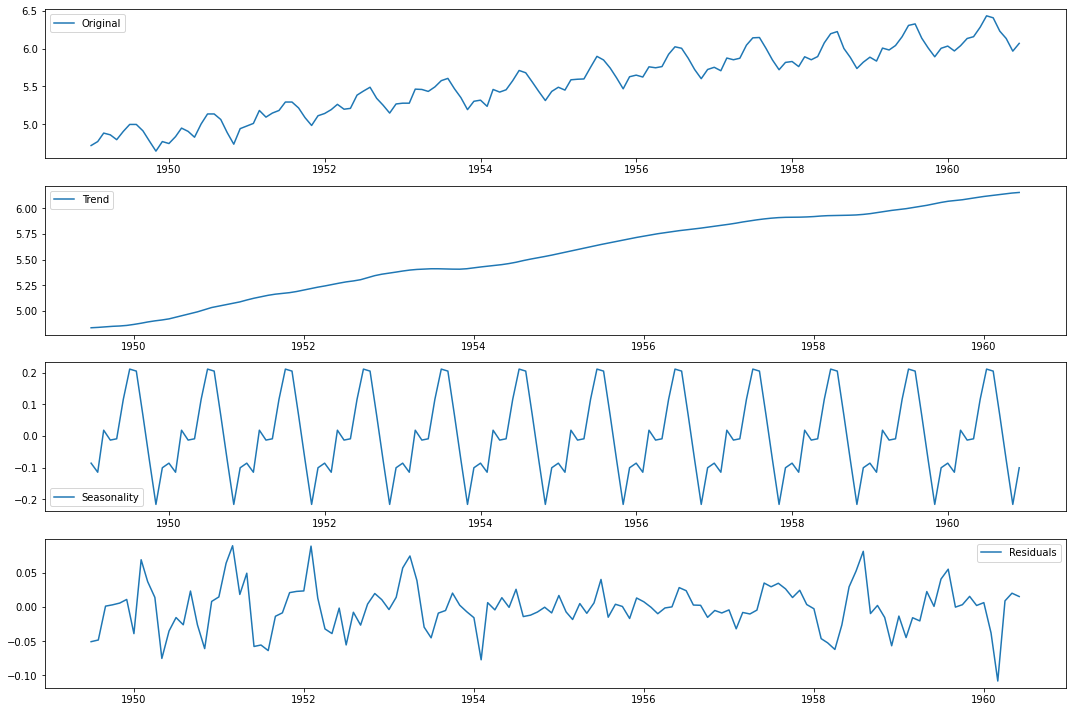

In [14]:
decomposition = seasonal_decompose(log_ts, model='aditive')
plot_decomposition(decomposition)

In [15]:
decomposition.resid.mean()

-0.000865680037373833

## Forecasting from decomposition

We now have the time series decomposed into components. The residual from decomposion does not look like anything else then noise with 0 mean.

The next natural step is to ask whether we can **use the decomposition to forecast** the future with assumption that the parts we explained will not change significantly.

But first, we should think about **testing the model** we are up to build. We indeed can take the data and just extrapolate the end for a year or two but then we have blindly trust the model we built.

Better approach would be to create a **validation set**, a standard technique used in ML everywhere.

For time series, we can trim the data at the end and use it as a validation set.

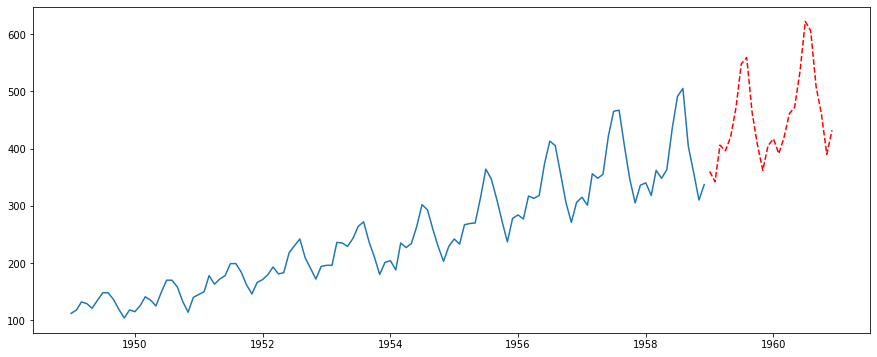

In [94]:
# let's take 2 years of data as a validation set
VALIDATION_MARK = 24

training_ts = ts[:-VALIDATION_MARK]
validation_ts = ts[-VALIDATION_MARK:]

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.show()

Now, let's **decompose the time series again** to not use validation data for forecasting

In [95]:
log_ts = np.log(training_ts)
decomposition = seasonal_decompose(log_ts, model='aditive')

### Forecasting trend

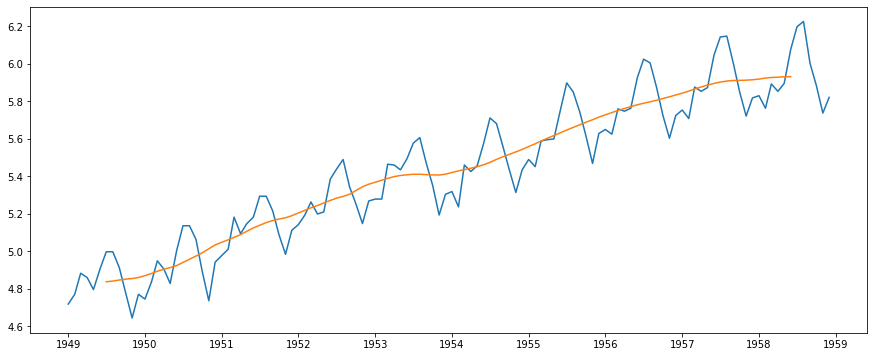

In [96]:
plt.plot(log_ts)
plt.plot(decomposition.trend)
plt.show()

We can approximate trend with simple linear regression (once the series is deflated with log. function).

There are many other approaches to extrapolate trend, but for simplicity, let's stay with this one.

In [97]:
from sklearn.linear_model import LinearRegression

X = (log_ts.index - log_ts.index[0]).days
X = np.expand_dims(X, -1)
Y = log_ts

reg = LinearRegression().fit(X, Y)

See the shape of the input data (2D tensor, multiple regressors are possible but not used here)

In [98]:
print(X.shape)

(120, 1)


Now, let's prepare a new date range (with extra two years for prediction) and extrapolate trend:

In [99]:
forecast_ts_index=pd.date_range(start='1949-01-01', periods=X.shape[0] + VALIDATION_MARK, freq='MS')

In [100]:
x = np.expand_dims((forecast_ts_index - forecast_ts_index[0]).days, -1)
forecast_trend = pd.Series(reg.predict(x), index=forecast_ts_index)

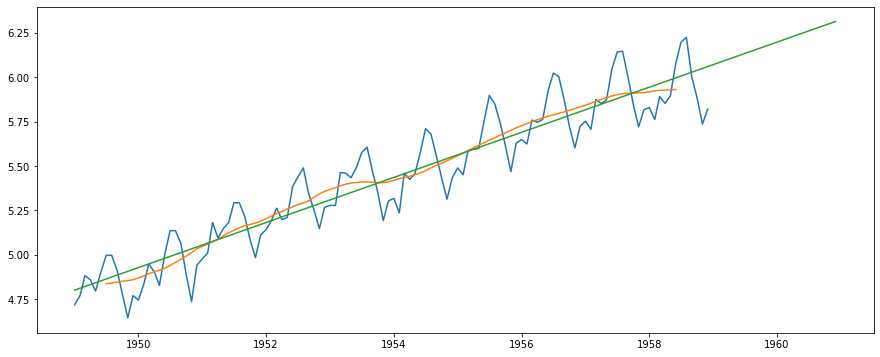

In [101]:
plt.plot(log_ts)
plt.plot(decomposition.trend)
plt.plot(forecast_trend)
plt.show()

### Forecasting seasonality

Next, we simply take the last year of seasonal component and use it as a forecasted seasonal effect.

In [102]:
season = decomposition.seasonal.values[-12:]
forecast_season = np.concatenate((decomposition.seasonal.values, season, season))

deflated_forecast = forecast_trend + forecast_season

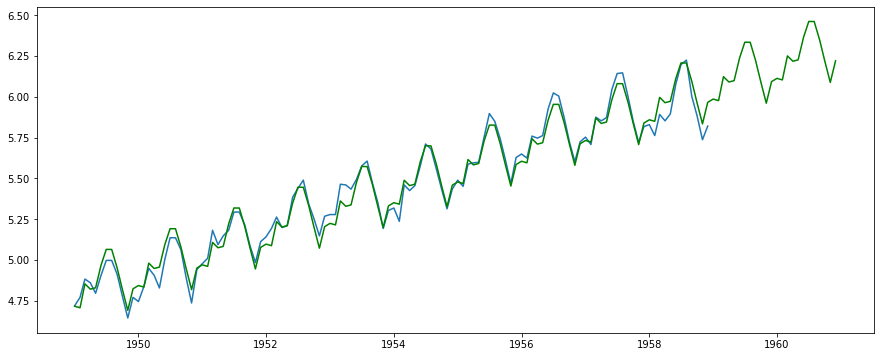

In [103]:
plt.plot(log_ts)
plt.plot(deflated_forecast, color='g')
plt.show()

Last, we need to inflate the series again to return it into the correct # passengers domain.

In [104]:
complete_forecast = np.exp(forecast_trend + forecast_season)

Finally, let's see how the forecast performs against the training and validation set. The simple squared error should be enough for future comparison.

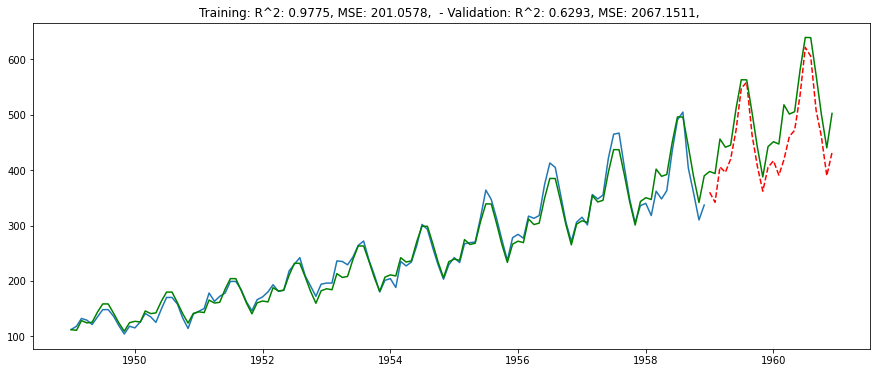

In [105]:
from sklearn.metrics import r2_score, mean_squared_error

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(complete_forecast, 'g')

def get_metrics(*args):
    return (
        f'R^2: {r2_score(*args):.4f}, ' +        
        f'MSE: {mean_squared_error(*args):.4f}, '        
    )

t_m = get_metrics(training_ts.values, complete_forecast.values[:-VALIDATION_MARK])
v_m = get_metrics(validation_ts.values, complete_forecast.values[-VALIDATION_MARK:])

plt.title(f'Training: {t_m} - Validation: {v_m}')

plt.show()

## ARIMA Models

Let's try to fit a stronger model onto our data now. We need to make the time series *stationary* before.

### Stationarity 

Stationarity is a useful concept for time series analysis as it tell's us something about stability of the time series over time. 

Time series is stationary if the following conditions are fulfilled:

1. The mean of the series should not be a function of time
2. The variance of the series should not a be a function of time
3. The covariance of the i-th term and the (i + k)-th term should not be a function of time

*Note: One should always consider a scale from which the data is viewed. 
For example, a quarter year of temperature data from Europe will not look stationary but if viewed on a daily basis, it can indeed seems like a stationary time series.*

Here are some examples of stationary (left) and non-stationary series violating conditions enlisted above (from left to right in the same order)

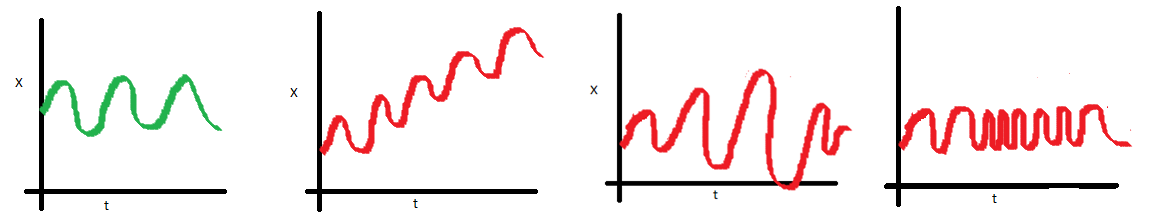

Stationary time series are easier to predict. We can just assume that if all the statistics are constant in time then they will remain constant in future as well. 

There's a statistical test for testing stationarity of the time series. It's called augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample which corresponts to "weak" stationarity of the time series.

In [28]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
        
    rolling = timeseries.rolling(center=False, window=12)        
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling.mean(), color='red', label='Rolling Mean')
    plt.plot(rolling.std(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
        
    
    df_test = adfuller(timeseries)
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        
    for key, value in sorted(df_test[4].items(), key=lambda x: x[1], reverse=True):
        output['Critical Value (%s)' % key] = value
        
    print('Dickey-Fuller test:')    
    print(output)

When ADF is applied to the original time series, the p-value clearly suggests that null hypothesis cannot be rejected i.e. the time series is not stationary.

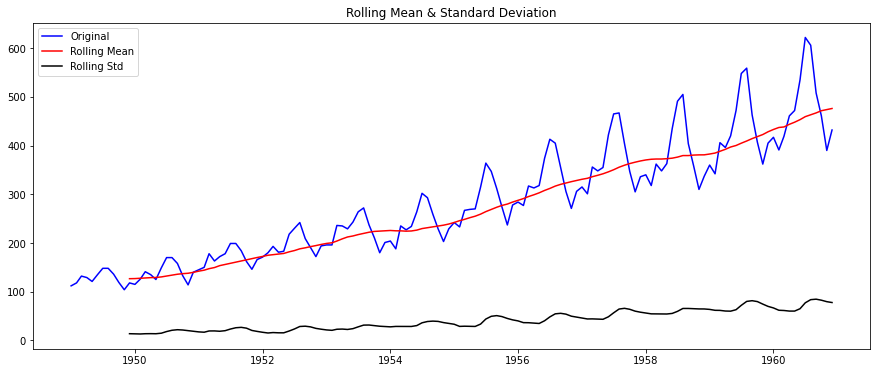

Dickey-Fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
dtype: float64


In [29]:
test_stationarity(ts)

In the previous example we transform (explain away) fixed components in order to get to the result we can assume is constant in time. This is exactly how "stationarized" time series should look like.

Let's test that with ADF test:

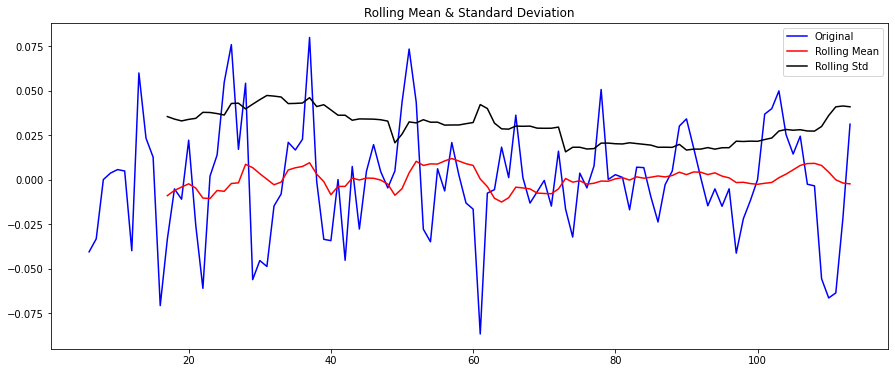

Dickey-Fuller test:
Test Statistic                -6.185134e+00
p-value                        6.316180e-08
#Lags Used                     7.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (10%)          -2.582435e+00
Critical Value (5%)           -2.890906e+00
Critical Value (1%)           -3.497501e+00
dtype: float64


In [30]:
test_stationarity(pd.Series(decomposition.resid.values).dropna())

^ As you can see, the test statistics is way below the critical values so is the p-value. We can safely say that the tested time series is stationary.

### Differencing

Differencing, a difference between the time series and a lagged version of itself, is another transformation which can help with when we want to "stationarize" a time series:

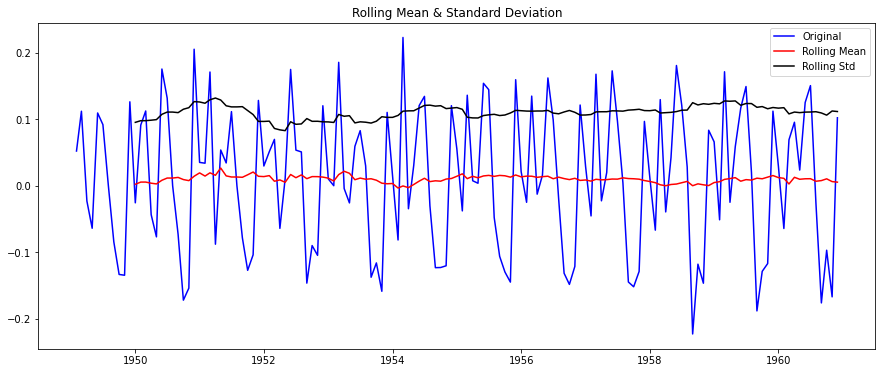

Dickey-Fuller test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (10%)            -2.578960
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
dtype: float64


In [31]:
ts_log = np.log(ts)
ts_log_diff = (ts_log - ts_log.shift()).dropna()

test_stationarity(ts_log_diff)

### Fitting ARIMA Model

Now, let's try to fit the ARIMA model (**A**uto**R**egressive **I**ntegrated **M**oving **A**verage) to our stationarized time serie. 

Parameters can be set by inspection of auto-correlation and partial auto-correlation plots. For more details on hyperparameter selection, [visit this site](http://people.duke.edu/~rnau/411home.htm)

After the model is fitted, we can plot it over original data. Notice that we are still in the transformed space.

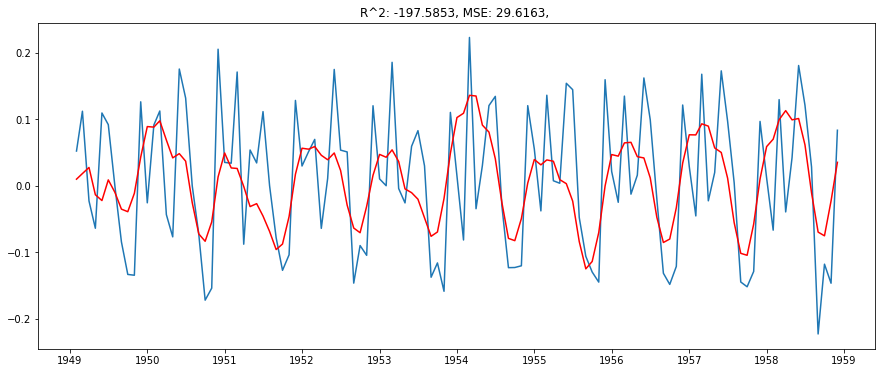

In [130]:
from statsmodels.tsa.arima_model import ARIMA
ts_log = np.log(training_ts)

model = ARIMA(ts_log, order=(2, 1, 3), freq="MS")  
results = model.fit(full_output=False, disp=False)

plt.plot(ts_log.diff())
plt.plot(results.fittedvalues, c='r')
plt.title(get_metrics(ts_log[1:], results.fittedvalues))
plt.show()

Last step is to inverse-transform the data back to the original domain.

As we took a log & difference, we need to apply them in reverse order (i.e. cumulative sum & exp). Also, notice that with difference we lost the constant and we need to replace it with the first value of the original dataset.

Same apply for prediction out of the sample (to the future) whre we use the last datapoint from the original time series

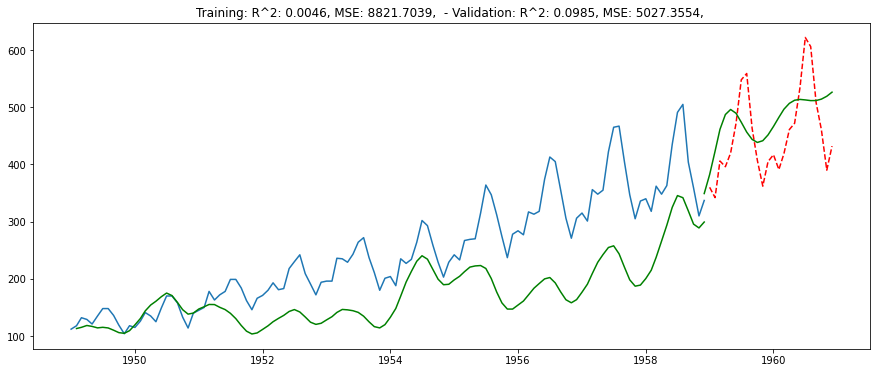

In [131]:
import datetime
from datetime import timedelta

prediction = results.predict(start=training_ts.index[-1], end=training_ts.index[-1] + timedelta(days=365 * 2 + 1), dynamic=True)

inflated = np.exp(results.fittedvalues.cumsum() + ts_log[0])
inflated_prediction = np.exp(prediction.cumsum() + ts_log[-1])

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(inflated, c='g')
plt.plot(inflated_prediction, c='g')
plt.title(
     f'Training: {get_metrics(training_ts[1:], inflated)} - Validation: {get_metrics(validation_ts, inflated_prediction[1:])}'    
)
plt.show()

The results are not very compelling. The strong seasonal part cannot be captured easily by the ARIMA model.

### SARIMAX Model

There are more advanced models like SARIMAX. The usage is very similar although there are two sets of hyper parameters. One for the global scale (same as in the ARIMA model) and the second for the local seasonal elements (acompanied with the season length)

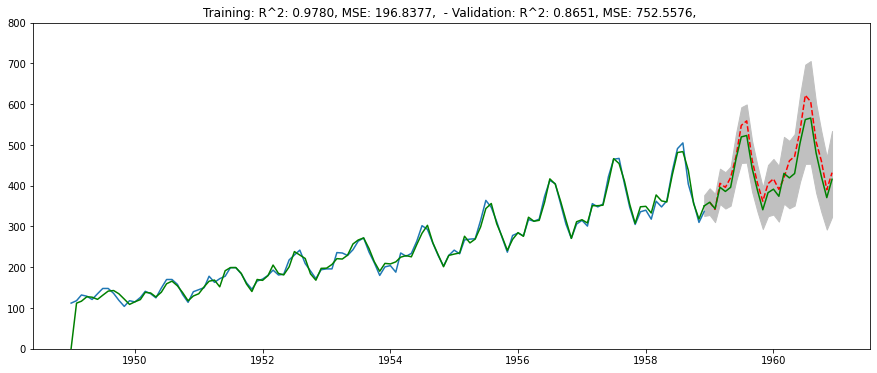

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

log_ts = np.log(training_ts)

model = SARIMAX(log_ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), freq="MS")
results = model.fit(maxiter=100)

prediction = results.get_prediction(start=training_ts.index[-1], end=training_ts.index[-1] + timedelta(days=365 * 2 + 1), dynamic=True)
conf_int = prediction.conf_int(alpha=0.05)

prediction_mean = np.exp(prediction.predicted_mean)
fitted = np.exp(results.fittedvalues)

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(fitted, c='g')
plt.plot(prediction_mean, c='g')
plt.fill_between(conf_int.index, np.exp(conf_int.iloc[:,0]), np.exp(conf_int.iloc[:,1]), color='silver')
plt.title(
    f'Training: {get_metrics(training_ts, fitted)} - Validation: {get_metrics(validation_ts, prediction_mean[1:])}'    
)
plt.ylim(0, 800)
plt.show()